In [1]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Class to get all data that is known


In [2]:

class DataSet ():
    def __init__(self, sequence):
        self.left_image_files = os.listdir('../dataset/00/image_2')
        self.right_image_files = os.listdir('../dataset/00/image_3')
        self.seq_dir = '../dataset/{}/'.format(sequence)
        self.initposC2,self.initC2k,self.intitC2r,self.intitC2t = self.Intrinsic_Matrix('P2')
        self.initposC3,self.initC3k,self.intitC3r,self.intitC3t = self.Intrinsic_Matrix('P3')
        
        self.index = 0
        self.first_image_left = cv2.imread(self.seq_dir + 'image_2/' 
                                               + self.left_image_files[0], 0)
        self.first_image_right = cv2.imread(self.seq_dir + 'image_3/' 
                                               + self.right_image_files[0], 0)
        self.second_image_left = cv2.imread(self.seq_dir + 'image_2/' 
                                               + self.left_image_files[1], 0)
        
        self.imheight = self.first_image_left.shape[0]
        self.imwidth = self.first_image_left.shape[1]

    def Intrinsic_Matrix(self, cam):
        calib = pd.read_csv(self.seq_dir + 'calib.txt', delimiter=' ', header=None, index_col=0)
        calib = np.array(calib.loc[f'{cam}:']).reshape((3,4))
        k1, r1, t1, _, _, _, _ = cv2.decomposeProjectionMatrix(calib)
        t1 = t1 / t1[3]
        return calib, k1, r1, t1
    
    def next_img(self):
        # Called a image generator every time this is called self.images go to next. Saves RAM
        if self.index >= len(self.left_image_files):
            print('No more images to display')
            return
        # Resets all generators to the first frame of the sequence
        self.images_left = cv2.imread(self.seq_dir + 'image_2/' + self.left_image_files[self.index], 0)
        self.images_right = cv2.imread(self.seq_dir + 'image_3/' + self.right_image_files[self.index], 0)
        self.index += 1 


# Disparity Map
bm = ~2,5* faster

In [29]:
def Left_Dismap(imgL,imgR, matcher='bm', rgb=False, verbose=False):
    sad_window = 6
    num_disparities = sad_window*16
    block_size = 11
    matcher_name = matcher
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size
                                     )
        
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 3 * sad_window ** 2,
                                        P2 = 32 * 3 * sad_window ** 2,
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                       )
    if rgb:
        imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
        imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    start = datetime.datetime.now()
    disp_left = matcher.compute(imgL, imgR).astype(np.float32)/16
    end = datetime.datetime.now()
    if verbose:
        print(f'Time to compute disparity map using Stereo{matcher_name.upper()}:', end-start)
    
    return disp_left

In [4]:
def calc_depth_map(D1, disp_left, k_left, t_left, t_right, rectified=True):   
    # Get focal length of x axis for left camera
    f = k_left[0][0]
    
    # Calculate baseline of stereo pair
    if rectified:
        b = t_right[0] - t_left[0] 
    else:
        b = t_left[0] - t_right[0]
        
    # Avoid instability and division by zero
    disp_left[disp_left == 0.0] = 0.1
    disp_left[disp_left == -1.0] = 0.1
    
    # Make empty depth map then fill with depth
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    #make mask
    mask = np.zeros(D1.first_image_left.shape[:2], dtype=np.uint8)
    ymax = D1.first_image_left.shape[0]
    xmax = D1.first_image_left.shape[1]
    cv2.rectangle(mask, (96,0), (xmax,ymax), (255), thickness = -1)
    return depth_map, mask

In [5]:
def extract_features(image, detector='sift', mask=None):
    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()
    elif detector == 'surf':
        det = cv2.xfeatures2d.SURF_create()
        
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

In [6]:
def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2):
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

In [7]:
def filter_matches_distance(matches, dist_threshold):
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

def visualize_matches(image1, kp1, image2, kp2, match):    
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

In [8]:
def estimate_motion(match, kp1, kp2, k, depth1=None, max_depth=3000):    
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    image1_points = np.float32([kp1[m.queryIdx].pt for m in match])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in match])

    if depth1 is not None:
        cx = k[0, 2]
        cy = k[1, 2]
        fx = k[0, 0]
        fy = k[1, 1]
        object_points = np.zeros((0, 3))
        delete = []

        # Extract depth information of query image at match points and build 3D positions
        for i, (u, v) in enumerate(image1_points):
            z = depth1[int(v), int(u)]
            # If the depth at the position of our matched feature is above 3000, then we
            # ignore this feature because we don't actually know the depth and it will throw
            # our calculations off. We add its index to a list of coordinates to delete from our
            # keypoint lists, and continue the loop. After the loop, we remove these indices
            if z > max_depth:
                delete.append(i)
                continue
                
            # Use arithmetic to extract x and y (faster than using inverse of k)
            x = z*(u-cx)/fx
            y = z*(v-cy)/fy
            object_points = np.vstack([object_points, np.array([x, y, z])])
            # Equivalent math with dot product w/ inverse of k matrix, but SLOWER (see Appendix A)
            #object_points = np.vstack([object_points, np.linalg.inv(k).dot(z*np.array([u, v, 1]))])

        image1_points = np.delete(image1_points, delete, 0)
        image2_points = np.delete(image2_points, delete, 0)
        
        # Use PnP algorithm with RANSAC for robustness to outliers
        _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
        #print('Number of inliers: {}/{} matched features'.format(len(inliers), len(match)))
        
        # Above function returns axis angle rotation representation rvec, use Rodrigues formula
        # to convert this to our desired format of a 3x3 rotation matrix
        rmat = cv2.Rodrigues(rvec)[0]
    
    else:
        # With no depth provided, use essential matrix decomposition instead. This is not really
        # very useful, since you will get a 3D motion tracking but the scale will be ambiguous
        image1_points_hom = np.hstack([image1_points, np.ones(len(image1_points)).reshape(-1,1)])
        image2_points_hom = np.hstack([image2_points, np.ones(len(image2_points)).reshape(-1,1)])
        E = cv2.findEssentialMat(image1_points, image2_points, k)[0]
        _, rmat, tvec, mask = cv2.recoverPose(E, image1_points, image2_points, k)
    
    return rmat, tvec, image1_points, image2_points

In [10]:
D1 = DataSet('00')
for i in range(4):
    D1.next_img()
    cv2.imshow(f"test{D1.index}",D1.images_left)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [36]:
Dis1 = Left_Dismap(D1.first_image_left,D1.first_image_right,'bm',verbose=True)
Dis2 = Left_Dismap(D1.first_image_left,D1.first_image_right,'sgbm',verbose=True)
Dis1v = cv2.convertScaleAbs(Dis1)
Dis2v = cv2.convertScaleAbs(Dis2)
Dis1v = cv2.applyColorMap(Dis1v, cv2.COLORMAP_OCEAN)
Dis2v = cv2.applyColorMap(Dis2v, cv2.COLORMAP_OCEAN)
cv2.imshow(f"BM",Dis1v)
cv2.imshow(f"SGBM",Dis2v)
cv2.waitKey(0)
cv2.destroyAllWindows()


Time to compute disparity map using StereoBM: 0:00:00.032984
Time to compute disparity map using StereoSGBM: 0:00:00.153918


(376, 1241)

The amount of useble depth: 87.24%


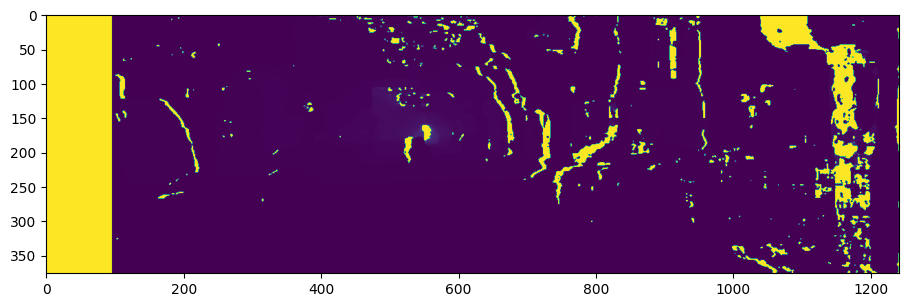

In [72]:
depth, mask = calc_depth_map(D1,Dis2,D1.initC2k,D1.intitC2t,D1.intitC3t)
plt.figure(figsize=(11,7))
plt.imshow(depth);
print(f"The amount of useble depth: {round(100-len(np.where(depth>3000)[0])/(D1.imheight*D1.imwidth)*100,2)}%")

Number of matches before filtering: 3865
Number of matches after filtering: 812


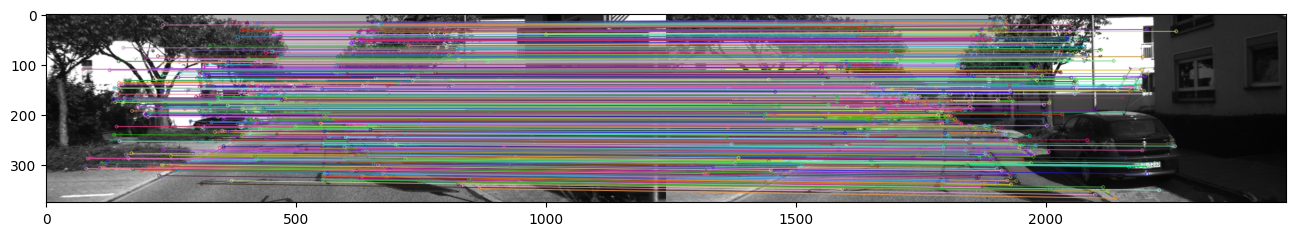

In [80]:
kp1,des1 = extract_features(D1.first_image_left,detector='sift',mask=None)
kp2,des2 = extract_features(D1.second_image_left,detector='sift',mask=None)
matches = match_features(des1, des2, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.45)
print('Number of matches after filtering:', len(matches))
visualize_matches(D1.first_image_left, kp1, D1.second_image_left, kp2, matches)

In [91]:
def estimate_motion(match, kp1, kp2, k, depth1=None, max_depth=3000):
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    image1_points = np.float32([kp1[m.queryIdx].pt for m in match])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in match])

    if depth1 is not None:
        cx = k[0, 2]
        cy = k[1, 2]
        fx = k[0, 0]
        fy = k[1, 1]
        object_points = np.zeros((0, 3))
        delete = []

        # Extract depth information of query image at match points and build 3D positions
        for i, (u, v) in enumerate(image1_points):
            z = depth1[int(v), int(u)]
            # If the depth at the position of our matched feature is above 3000, then we
            # ignore this feature because we don't actually know the depth and it will throw
            # our calculations off. We add its index to a list of coordinates to delete from our
            # keypoint lists, and continue the loop. After the loop, we remove these indices
            if z > max_depth:
                delete.append(i)
                continue
                
            # Use arithmetic to extract x and y (faster than using inverse of k)
            x = z*(u-cx)/fx
            y = z*(v-cy)/fy
            object_points = np.vstack([object_points, np.array([x, y, z])])
            # Equivalent math with dot product w/ inverse of k matrix, but SLOWER (see Appendix A)
            #object_points = np.vstack([object_points, np.linalg.inv(k).dot(z*np.array([u, v, 1]))])

        image1_points = np.delete(image1_points, delete, 0)
        image2_points = np.delete(image2_points, delete, 0)
        
        # Use PnP algorithm with RANSAC for robustness to outliers
        _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
        #print('Number of inliers: {}/{} matched features'.format(len(inliers), len(match)))
        
        # Above function returns axis angle rotation representation rvec, use Rodrigues formula
        # to convert this to our desired format of a 3x3 rotation matrix
        rmat = cv2.Rodrigues(rvec)[0]
    
    else:
        # With no depth provided, use essential matrix decomposition instead. This is not really
        # very useful, since you will get a 3D motion tracking but the scale will be ambiguous
        image1_points_hom = np.hstack([image1_points, np.ones(len(image1_points)).reshape(-1,1)])
        image2_points_hom = np.hstack([image2_points, np.ones(len(image2_points)).reshape(-1,1)])
        E = cv2.findEssentialMat(image1_points, image2_points, k)[0]
        _, rmat, tvec, mask = cv2.recoverPose(E, image1_points, image2_points, k)
    
    Tmat = np.eye(4)
    # Place resulting rotation matrix  and translation vector in their proper locations
    # in homogeneous T matrix
    Tmat[:3, :3] = rmat
    Tmat[:3, 3] = tvec.T
    
    return Tmat, image1_points, image2_points

In [92]:
Tmat,image1_points,image2_points = estimate_motion(matches, kp1, kp2, D1.initC2k, depth1=None, max_depth=3000)


In [93]:
Tmat


array([[ 0.99999423,  0.00246673,  0.00233599,  0.02173691],
       [-0.00247145,  0.99999491,  0.00201599,  0.0159124 ],
       [-0.002331  , -0.00202175,  0.99999524, -0.99963709],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

Make route visble
make pointcloud with first image featers
Add second pointcloud with pos translation matrix
repeat for rest pic